## analysis script for capital_const_plan experiments.

In [1]:
#Imports
from marketsai.economies.capital_mkts.capital_const_plan import CapitalConstPlan
import scipy.io as sio
from scipy.interpolate import RegularGridInterpolator
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init


/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = True  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_PROGRESS = True  # create plot with progress
SIMUL_PERIODS = 10000
# Input Directories
# Rl experiment
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_multi_hh_cap_const_plan_run_Aug26_PPO.json"

# GDSGE policy
dir_policy_folder = (
    "/Users/matiascovarrubias/Dropbox/RL_macro/Econ_algos/capital_const_plan/Results/"
)

# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
    

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)

In [3]:
""" Step 0: import experiment data and create output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)

# UNPACK USEFUL DATA
n_agents_list = exp_data_dict["n_agents"]
exp_names = exp_data_dict["exp_names"]
checkpoints_dirs = exp_data_dict["checkpoints"]
progress_csv_dirs = exp_data_dict["progress_csv_dirs"]
best_rewards = exp_data_dict["best_rewards"]

#Create output directory
exp_data_analysis_dict =  {"n_hh": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[],  "Mean Price": [], "S.D. Price": []}
exp_data_simul_dict = {"n_hh": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[],  "Mean Price": [], "S.D. Price": []}
# init ray
shutdown()
init()

2021-08-29 21:29:07,526	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.202',
 'raylet_ip_address': '192.168.1.202',
 'redis_address': '192.168.1.202:22197',
 'object_store_address': '/tmp/ray/session_2021-08-29_21-29-04_329173_26290/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-29_21-29-04_329173_26290/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-08-29_21-29-04_329173_26290',
 'metrics_export_port': 61207,
 'node_id': '5a9563cf0a69b651302e3441477a90959926e0f28adf89bc6848061e'}

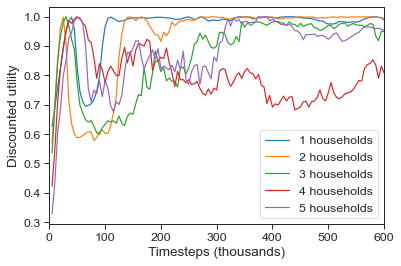

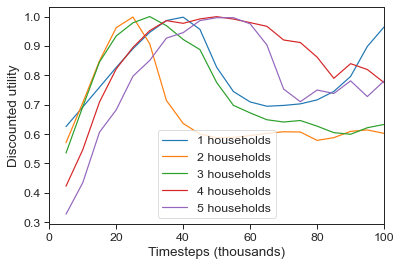

In [4]:
""" Step 1: Plot progress """

if PLOT_PROGRESS == True:
    #Big plot
    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        exp_data_simul_dict["max rewards"].append(max_rewards)
        exp_data_simul_dict["time to peak"].append(0)
        exp_data_analysis_dict["max rewards"].append(max_rewards)
        exp_data_analysis_dict["time to peak"].append(0)
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / max_rewards
        )
        learning_plot_big = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_big = learning_plot_big.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 600])
    plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    learning_plot_big.savefig(OUTPUT_PATH_FIGURES + "progress_BIG_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()

    # small plot
    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / max_rewards
        )
        learning_plot_small = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_small = learning_plot_small.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 100])
    plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    learning_plot_small.savefig(OUTPUT_PATH_FIGURES + "progress_SMALL_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()


2021-08-29 21:29:14,750	INFO trainer.py:694 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=26457) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26457) Instructions for updating:
(pid=26457) non-resource variables are not supported in the long term
(pid=26454) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26454) Instructions for updating:
(pid=26454) non-resource variables are not supported in t

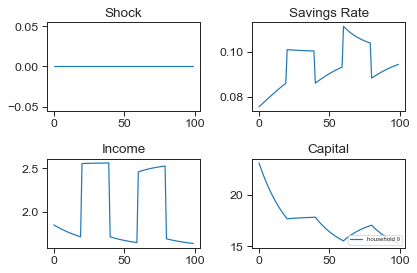

(pid=26456) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26456) Instructions for updating:
(pid=26456) non-resource variables are not supported in the long term
(pid=26458) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26458) Instructions for updating:
(pid=26458) non-resource variables are not supported in the long term
2021-08-29 21:29:32,536	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_2hh_cap_co

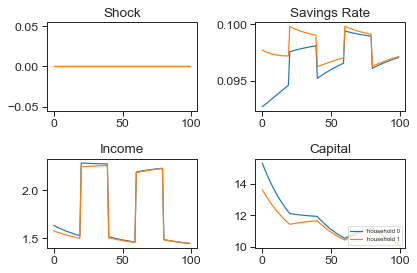

(pid=26455) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26455) Instructions for updating:
(pid=26455) non-resource variables are not supported in the long term
(pid=26453) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26453) Instructions for updating:
(pid=26453) non-resource variables are not supported in the long term
2021-08-29 21:29:45,702	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_3hh_cap_co

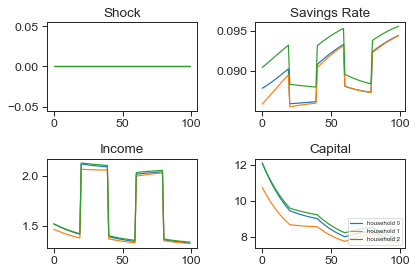

(pid=26451) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26451) Instructions for updating:
(pid=26451) non-resource variables are not supported in the long term
(pid=26450) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26450) Instructions for updating:
(pid=26450) non-resource variables are not supported in the long term
2021-08-29 21:30:01,499	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_4hh_cap_co

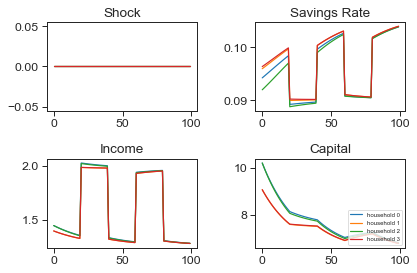

(pid=26447) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26447) Instructions for updating:
(pid=26447) non-resource variables are not supported in the long term
(pid=26448) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26448) Instructions for updating:
(pid=26448) non-resource variables are not supported in the long term
2021-08-29 21:30:20,674	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_5hh_cap_co

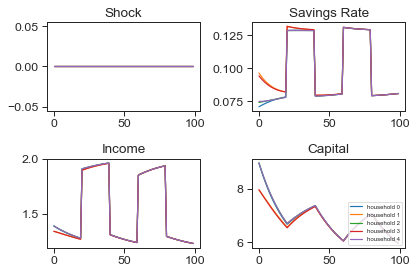

{'n_hh': [1, 2, 3, 4, 5], 'max rewards': [36.15150592603779, 29.098781364595855, 25.79427590372985, 22.94592750033146, 21.178018365400117], 'time to peak': [0, 0, 0, 0, 0], 'Mean Agg. K': [16.19118892092055, 21.259430469452123, 24.091839712877505, 27.97417582960605, 32.37977895533909], 'S.D. Agg. K': [0.8304011162952275, 0.9694556753208007, 1.2538198158299734, 1.207334824453866, 1.8696970140926754], 'Max K': [23.070843176993726, 15.345710435576311, 12.089376568377975, 10.207291817031962, 8.951681899534016], 'Min K': [15.17644400111157, 10.089000939372852, 7.625413088272503, 6.7427929093819365, 5.883010312466101], 'Mean Agg. s': [0.09957269601523876, 0.09810247840887931, 0.09135291140477288, 0.09698715036893125, 0.10520057356806341], 'S.D. Agg. s': [0.008711188392624894, 0.0014271942955932143, 0.0028992921480006806, 0.006096175417946357, 0.025108949162860925], 'Max s': [0.11341688632965087, 0.09999371767044066, 0.09559910595417022, 0.10418893396854399, 0.1320142239332199], 'Min s': [0.0

In [5]:

""" Step 2: Congif, Restore RL policy and then simualte analysis trajectory """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate(n_agents_list):
    """ Step 2.0: replicate original environemnt and config """
    env_label = "capital_const_plan"
    register_env(env_label, CapitalConstPlan)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_analysis = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": False,
        "analysis_mode": True,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalConstPlan(env_config_analysis)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_analysis,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 2.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Step 2: Simulate an episode (MAX_steps timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(env_horizon):
        action = {}
        for i in range(env.n_hh):
            action[f"hh_{i}"] = trained_trainer.compute_action(
                obs[f"hh_{i}"], policy_id="hh"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_hh)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_hh)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_hh)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_hh)]))
        p_list[ind].append(info["hh_0"]["price"][0])

    """ Step 2.2: Calculate Statistics and save in table """


    exp_data_analysis_dict["n_hh"].append(n_hh)
    exp_data_analysis_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_analysis_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_analysis_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_analysis_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_analysis_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_analysis_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_analysis_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_analysis_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_analysis_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_analysis_dict["S.D. Price"].append(np.std(p_list[ind]))


    """ Step 2.3: Plot trajectories """

    # Idiosyncratic trajectories
    x = [i for i in range(100)]
    plt.subplot(2, 2, 1)
    for i in range(env.n_hh):
        sn.lineplot(x,shock_idtc_list[i][:100], label = f"household {i}", legend=0)
    plt.title("Shock")

    plt.subplot(2, 2, 2)
    for i in range(env.n_hh):
        sn.lineplot(x,s_list[i][:100], label = f"household {i}", legend=0)
    plt.title("Savings Rate")

    plt.subplot(2, 2, 3)
    for i in range(env.n_hh):
        sn.lineplot(x,y_list[i][:100], label = f"household {i}", legend=0)
    plt.title("Income")

    plt.subplot(2, 2, 4)
    # plt.plot(k_agg_list[:100])
    for i in range(env.n_hh):
        sn.lineplot(x,k_list[i][:100], label = f"household {i}", legend=0)
    plt.title("Capital")
    
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower right', prop={'size': 6})
    #plt.legend(labels=[f"{i+1} households" for i in range(env.n_hh)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names[ind] + ".png")
    plt.show()
    plt.close()
 
    
    # """ Step 2.3 Run simulation on policies calculated with GDSGE """

    # dir_model = f"cap_market_{n_hh}hh_5pts"
    # matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
    # K = [
    #     np.array(matlab_struct["IterRslt"]["var_state"][f"K_{i+1}"])
    #     for i in range(n_hh)
    # ]
    # shock = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
    # s_on_grid = [
    #     matlab_struct["IterRslt"]["var_policy"][f"s_{i+1}"] for i in range(n_hh)
    # ]  # type numpy.ndarray

    # s_interp = [
    #     RegularGridInterpolator((shock,) + tuple(K), s_on_grid[i]) for i in range(n_hh)
    # ]

    # sample_obs = env.observation_space.sample()
    # sample_K = obs[0]
    # sample_ind_shock = sample_obs[1]
    # sample_agg_shock = sample_obs[2]

    # #debug this and make sure that it makes sense. 
    # sample_shock_raw = [sample_agg_shock] + list(sample_ind_shock)
    # sample_shock_id = encode(sample_shock_raw, dims=[2 for i in range(n_hh + 1)])
    # pts = [sample_shock_id] + list(sample_K)
    # sample_s = [s_interp[i](pts)[0] for i in range(env.n_hh)]


    # def compute_action(obs, policy_list: list, max_action: float):
    #     # to do, check encode part
    #     K = obs[0][0]
    #     shock_raw = [obs[2], obs[1][0]]
    #     shock_id = encode(shock_raw, dims=[2 for i in range(n_hh)]) #change_dims
    #     s = [policy_list[i](np.array([shock_id] + K)) for i in range(env.n_hh)]
    #     action = np.array([2 * s[i] / max_action - 1 for i in range(env.n_hh)])
    #     return action


    # shock_list_econ = [[] for i in range(env.n_hh)]
    # s_list_econ = [[] for i in range(env.n_hh)]
    # inv_list_econ = [[] for i in range(env.n_hh)]
    # y_list_econ = [[] for i in range(env.n_hh)]
    # c_list_econ = [[] for i in range(env.n_hh)]
    # k_list_econ = [[] for i in range(env.n_hh)]
    # rew_list_econ = [[] for i in range(env.n_hh)]
    # MAX_STEPS = env.horizon
    # # MAX_STEPS = 100
    # obs = env.reset()
    # for i in range(MAX_STEPS):
    #     action = compute_action(obs, s_interp, env.max_s_per_j)
    #     obs, rew, done, info = env.step(action)
    #     # obs[1] = shock_process[i]
    #     # env.obs_[1] = shock_process[i]
    #     for i in range(env.n_hh):
    #         shock_list_econ[i].append(obs[1][i])
    #         s_list_econ[i].append(info["savings"][i][0])
    #         inv_list_econ[i].append(info["investment"][i][0])
    #         y_list_econ[i].append(info["income"][i])
    #         c_list_econ[i].append(info["consumption"][i])
    #         k_list_econ[i].append(info["capital"][i][0])
    #         rew_list_econ[i].append(info["reward"][i])
print(exp_data_analysis_dict)

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y

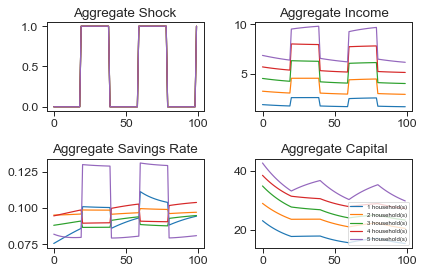

In [6]:
""" Step 3: Create aggregate plots"""

x = [i for i in range(100)]
plt.subplot(2, 2, 1)
for i in range(len(n_agents_list)):
    sn.lineplot(x,shock_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Shock")

plt.subplot(2, 2, 2)
for i in range(len(n_agents_list)):
    sn.lineplot(x,y_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Income")

plt.subplot(2, 2, 3)
for i in range(len(n_agents_list)):
    sn.lineplot(x,s_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Savings Rate")

plt.subplot(2, 2, 4)
for i in range(len(n_agents_list)):
    sn.lineplot(x,k_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
plt.savefig(OUTPUT_PATH_FIGURES + "SimAgg_" + exp_names[-1] + ".png")
plt.show()
plt.close()

In [7]:
""" Step 4: Simulate the model and get statistics """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
k_max_list = [[] for i in n_agents_list]
k_min_list = [[] for i in n_agents_list]
s_max_list = [[] for i in n_agents_list]
s_min_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]
p_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate(n_agents_list):
    """ Step 4.0: replicate original environemnt and config """
    env_label = "capital_const_plan"
    register_env(env_label, CapitalConstPlan)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_simul = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "simul_mode": True,
        "analysis_mode": False,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalConstPlan(env_config_simul)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_simul,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 4.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Simulate an episode (SIMUL_PERIODS timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(SIMUL_PERIODS):
        action = {}
        if t%1000 == 0:
            obs=env.reset()
        for i in range(env.n_hh):
            action[f"hh_{i}"] = trained_trainer.compute_action(
                obs[f"hh_{i}"], policy_id="hh"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))
        k_max_list[ind].append(np.max([k_list[i][t] for i in range(env.n_hh)]))
        k_min_list[ind].append(np.min([k_list[i][t] for i in range(env.n_hh)]))
        s_max_list[ind].append(np.max([s_list[i][t] for i in range(env.n_hh)]))
        s_min_list[ind].append(np.min([s_list[i][t] for i in range(env.n_hh)]))
        p_list[ind].append(info["hh_0"]["price"][0])

    exp_data_simul_dict["n_hh"].append(n_hh)
    exp_data_simul_dict["Mean Agg. K"].append(np.mean(k_agg_list[ind]))
    exp_data_simul_dict["S.D. Agg. K"].append(np.std(k_agg_list[ind]))
    exp_data_simul_dict["Max K"].append(np.max(k_max_list[ind]))
    exp_data_simul_dict["Min K"].append(np.min(k_min_list[ind]))
    exp_data_simul_dict["Mean Agg. s"].append(np.mean(s_agg_list[ind]))
    exp_data_simul_dict["S.D. Agg. s"].append(np.std(s_agg_list[ind]))
    exp_data_simul_dict["Max s"].append(np.max(s_max_list[ind]))
    exp_data_simul_dict["Min s"].append(np.min(s_min_list[ind]))
    exp_data_simul_dict["Mean Price"].append(np.mean(p_list[ind]))
    exp_data_simul_dict["S.D. Price"].append(np.std(p_list[ind]))

(pid=26449) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26449) Instructions for updating:
(pid=26449) non-resource variables are not supported in the long term
(pid=26446) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=26446) Instructions for updating:
(pid=26446) non-resource variables are not supported in the long term
2021-08-29 21:30:46,016	INFO trainable.py:377 -- Restored on 192.168.1.202 from checkpoint: /Users/matiascovarrubias/ray_results/native_1hh_cap_co

In [8]:
""" Stape 4: Table with moments """
exp_table_df = pd.DataFrame.from_dict(exp_data_simul_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_df.to_latex())

exp_table_small_df=exp_table_df[["n_hh","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'SMALL_TABLE.tex','w') as tf:
    tf.write(exp_table_small_df.to_latex())




In [9]:
""" Step 5: Compare with GDSGE policy """
# To do:
# 2. check that the structure of the interpolation is done corretly.
# 3. create return from the function.

#should I do that in the loop? probably yes!



' Step 5: Compare with GDSGE policy '